In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper', font_scale=1.6)
import keras.backend as K
from natsort import natsorted

SEED = 0
SAVE_PLOTS = False

Using TensorFlow backend.


In [2]:
import glob
import os

def parse_logs(log_files):
    max_epoch = 250
    logs = [pd.read_csv(f, index_col='epoch', parse_dates=[1]) for f in log_files]
    for log, f in zip(logs, log_files):
        run = f.split('/')[-2]
        log.drop(log.index[log.index > max_epoch], axis=0, inplace=True)
        if 'time' not in log:
            raise ValueError("Missing times from {}".format(f))
        log.columns = ['time', run + ' Train', run + ' Valid']
        log['time'] = (log['time'] - log['time'].min()) / np.timedelta64(1, 's')
    step_logs = pd.concat([l.drop('time', axis=1, inplace=False) for l in logs], axis=1)
    time_logs = pd.concat([l.set_index('time') for l in logs], axis=1)
    
    return step_logs, time_logs

In [3]:
LABEL_MAP = {'epoch': 'Epoch', 'time': 'Time (s)'}

def run_to_args(run):
    values = run.split(' ')[0].split('_')
    args = {'model_type': values[0].upper(), 'size': int(values[1]), 
            'num_layers': int(values[2].strip('x')),
            'drop_frac': float(values[4].strip('drop')),
            'bidirectional': 'bidir' in run}
    if 'emb' in run:
        args['embedding'] = int([v for v in values if 'emb' in v][0][3:])
    return args
    

def training_plot(logs, loss_type='Valid', ylim=(1e-2, 1e0)):
    fig = plt.figure()
    colors = sns.color_palette(n_colors=int(len(logs.columns) / 2))
    for i, c in enumerate(step_logs.columns):
        if loss_type is not None and loss_type not in c:
            continue
        to_plot = logs[c]
        to_plot.dropna(inplace=True)
        args = run_to_args(c)
        to_plot.name = "{model_type}({size}) x {num_layers}".format(**args)
        if 'embedding' in args:
            to_plot.name += ", Embedding={}".format(args['embedding'])
        to_plot.plot(color=colors[int(i / 2)], legend=True, logy=True)
    plt.xlabel(LABEL_MAP[logs.index.name])
    plt.ylabel('Loss')
    plt.ylim(ylim)
    return fig

In [4]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred, classnames, filename=None):
    classnames = sorted(classnames)
    sns.set_style("whitegrid", {'axes.grid' : False})
    cm = confusion_matrix(y_test, y_pred, classnames)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    #plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classnames))
    plt.xticks(tick_marks, classnames, rotation=45)
    plt.yticks(tick_marks, classnames)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label');
    if filename:
        plt.savefig(filename)

In [5]:
from copy import deepcopy
from sklearn.model_selection import GridSearchCV, ParameterGrid

RF_PARAM_GRID = {'n_estimators': [50, 100, 250], 'criterion': ['gini', 'entropy'],
                 'max_features': [0.05, 0.1, 0.2, 0.3], 'min_samples_leaf': [1, 2, 3]}
#RF_PARAM_GRID = {'bootstrap': [True],
# 'class_weight': [None],
# 'criterion': ['entropy'],
# 'max_depth': [None],
# 'max_features': [0.3],
# 'max_leaf_nodes': [None],
# 'min_impurity_split': [1e-07],
# 'min_samples_leaf': [1],
# 'min_samples_split': [2],
# 'min_weight_fraction_leaf': [0.0],
# 'n_estimators': [250],
# 'n_jobs': [1],
# 'oob_score': [False],
# 'random_state': [0],
# 'verbose': [0],
# 'warm_start': [False]}

def oob_search(model, param_lists, X, y):
    best_model = None
    best_params = None
    best_score = -np.inf
    
    for g in ParameterGrid(param_lists):
        model.set_params(**g)
        model.fit(X, y)
        if model.oob_score_ > best_score:
            best_score = model.oob_score_
            best_params = g
            best_model = deepcopy(model)
            
    return best_model, best_params, best_score

## Period estimator training plots

## Autoencoder training plots

## ASAS reconstructions

In [7]:
%%time
import os
import joblib
from keras_util import get_run_id
from survey_autoencoder import main as survey_autoencoder

arg_dict = {'size': 64, 'embedding': 64, 'num_layers': 1, 'model_type': 'gru',
            'sim_type': 'asas_full/n200_ss0.7', 'n_min': 200, 'n_max': 200,
            'lr': 1e-3, 'bidirectional': True, 'ss_resid': 0.7,
            'drop_frac': 0.25, 'survey_files': ['data/asas/full.pkl'],
            'period_fold': False, 'no_train': True}
run = get_run_id(**arg_dict)
log_dir = os.path.join(os.getcwd(), 'keras_logs', arg_dict['sim_type'], run)
weights_path = os.path.join(log_dir, 'weights.h5')
if not os.path.exists(weights_path):
    raise FileNotFoundError(weights_path)
X, X_raw, model, means, scales, wrong_units, args = survey_autoencoder(arg_dict)
full = joblib.load('data/asas/full.pkl')
split = [el for lc in full for el in lc.split(args.n_min, args.n_max)]
if args.ss_resid:
    split = [el for el in split if el.ss_resid <= args.ss_resid]

[]
Loading /Users/brettnaul/Dropbox/Documents/timeflow/keras_logs/asas_full/n200_ss0.7/gru_064_x1_1m03_drop25_emb64_bidir/weights.h5...
CPU times: user 30.3 s, sys: 2.71 s, total: 33.1 s
Wall time: 33.4 s


In [8]:
(len(X), 0.8 * len(X), 0.2 * len(X))

(33103, 26482.4, 6620.6)

27594
7797
CPU times: user 642 ms, sys: 426 ms, total: 1.07 s
Wall time: 1.41 s


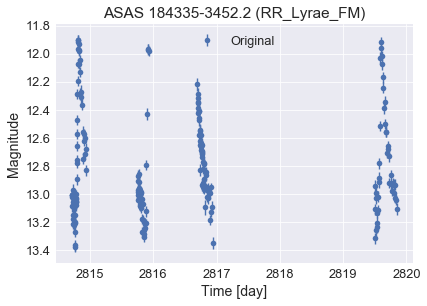

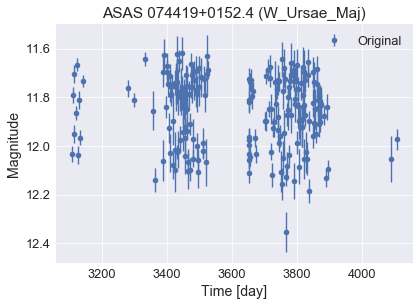

In [10]:
%%time
#pred = model.predict({'main_input': X[:], 'aux_input': X[:, :, [0,]]})
#ords = np.argsort(np.sum((pred.squeeze() - X[:, :, 1]) ** 2, axis=1))
inds, labels = zip(*[(8320, '25'), (23994, '75')])
for ord_i, label in zip(inds, labels):
    i = ords[ord_i]
    print(i)
    t = X_raw[~wrong_units][i, :, 0]
    m = X_raw[~wrong_units][i, :, 1]
    e = X_raw[~wrong_units][i, :, 2]
    m_est = pred[i] * scales[i, 0] + means[i]
    plt.figure()
    plt.errorbar(t, m, e, None, 'o');
#    plt.errorbar(t, m_est, None, None, 'o');
    plt.xlabel('Time [day]')
    plt.ylabel('Magnitude')
    plt.legend(['Original', 'Reconstructed'])
    plt.title(f'{split[i].survey} {split[i].name} ({split[i].label})')
    plt.gca().invert_yaxis()
    if 1:
        plt.savefig(f'paper/figures/asas_reconstruct_{label}.pdf')

In [ ]:
%%time
import os
from keras_util import get_run_id
from survey_autoencoder import main as survey_autoencoder

arg_dict = {'size': 64, 'embedding': 64, 'num_layers': 1, 'model_type': 'gru',
            'sim_type': 'asas_fold/n200', 'n_min': 200, 'n_max': 200,
            'lr': 1e-3, 'bidirectional': True, 'ss_resid': 0.7,
            'drop_frac': 0.25, 'survey_files': ['data/asas/full.pkl'],
            'period_fold': True, 'no_train': True}
run = get_run_id(**arg_dict)
log_dir = os.path.join(os.getcwd(), 'keras_logs', arg_dict['sim_type'], run)
weights_path = os.path.join(log_dir, 'weights.h5')
if not os.path.exists(weights_path):
    raise FileNotFoundError(weights_path)
X_fold, X_raw_fold, model, means, scales, wrong_units, args = survey_autoencoder(arg_dict)

In [ ]:
pred_fold = model.predict({'main_input': X_fold[:], 'aux_input': X_fold[:, :, [0,]]})
ords_fold = np.argsort(np.sum((pred_fold.squeeze() - X_fold[:, :, 1]) ** 2, axis=1))
for ord_i, label in zip(inds, labels):
    i = ords[ord_i]
    t = X_raw_fold[~wrong_units][i, :, 0]
    m = X_raw_fold[~wrong_units][i, :, 1]
    e = X_raw_fold[~wrong_units][i, :, 2]
    m_est = (pred[i] * scales[i, 0] + means[i])[np.argsort(split[i].times % split[i].p)]
    m_fold = pred_fold[i] * scales[i, 0] + means[i]
    plt.figure()
    plt.errorbar(t, m, e, None, 'o');
    plt.errorbar(t, m_est, None, None, 'o', alpha=0.6);
    plt.errorbar(t, m_fold, None, None, 'o');
    plt.xlabel('Phase [day]')
    plt.ylabel('Magnitude')
    plt.title(f'{split[i].survey} {split[i].name} ({split[i].label})')
    plt.legend(['Original', 'Reconstructed (non-folded)', 'Reconstructed (folded)'])
    plt.gca().invert_yaxis()
    if SAVE_PLOTS:
        plt.savefig(f'figures/asas_folded_reconstruct_{label}.pdf')

## ASAS autoencoder random forests

In [ ]:
%%time
import os
import joblib
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from light_curve import LightCurve
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras_util import get_run_id
from survey_autoencoder import main as survey_autoencoder, preprocess

arg_dict = {'size': 64, 'embedding': 64, 'num_layers': 1, 'model_type': 'gru',
            'sim_type': 'asas_fold/n200_noise', 'n_min': 200, 'n_max': 200,
            'lr': 1e-3, 'bidirectional': True, 'ss_resid': 0.7,
            'drop_frac': 0.25, 'survey_files': ['data/asas/full.pkl'],
            'period_fold': True, 'no_train': True}
run = get_run_id(**arg_dict)
log_dir = os.path.join(os.getcwd(), 'keras_logs', arg_dict['sim_type'], run)
weights_path = os.path.join(log_dir, 'weights.h5')
if not os.path.exists(weights_path):
    raise FileNotFoundError(weights_path)
X, X_raw, model, means, scales, wrong_units, args = survey_autoencoder(arg_dict)

top_classes = ['RR_Lyrae_FM', 'W_Ursae_Maj', 'Classical_Cepheid', 'Beta_Persei', 'Semireg_PV']
full = joblib.load('data/asas/full.pkl')
full = [lc for lc in full if lc.label in top_classes]
split = [el for lc in full for el in lc.split(args.n_min, args.n_max)]
#if args.ss_resid:
#    split = [el for el in split if el.ss_resid <= args.ss_resid]
if args.period_fold:
    for lc in split:
        lc.period_fold()
X_list = [np.c_[lc.times, lc.measurements, lc.errors] for lc in split]
classnames, indices = np.unique([lc.label for lc in split], return_inverse=True)
periods = [lc.p for lc in split]
y = classnames[indices]
train, valid = list(StratifiedKFold(n_splits=5, random_state=SEED).split(X_list, y))[0]

X_raw = pad_sequences(X_list, value=0., dtype='float', padding='post')
X, means, scales, wrong_units = preprocess(X_raw, args.m_max)
encode_model = Model(input=model.input, output=model.get_layer('encoding').output)
encoding = encode_model.predict({'main_input': X, 'aux_input': np.delete(X, 1, axis=2)})
encoding = np.c_[encoding, means, scales, periods]

In [ ]:
len(fset)

In [ ]:
%%time
#asas_model = RandomForestClassifier(oob_score=True)
#asas_model, best_params, oob_score = oob_search(asas_model, RF_PARAM_GRID, encoding[train], y[train])
asas_model = GridSearchCV(RandomForestClassifier(random_state=0), RF_PARAM_GRID)
asas_model.fit(encoding[train], y[train])
print("Training score: {}%".format(100 * asas_model.score(encoding[train], y[train])))
print("Validation score: {}%".format(100 * asas_model.score(encoding[valid], y[valid])))
plot_confusion_matrix(y[valid], asas_model.predict(encoding[valid]), classnames,
                      'figures/asas_confusion.pdf' if SAVE_PLOTS else None)

## ASAS Richards random forests

In [ ]:
%%time
from sklearn.model_selection import StratifiedKFold
from light_curve import LightCurve
import joblib
from cesium.features import LOMB_SCARGLE_FEATS, CADENCE_FEATS, GENERAL_FEATS
from cesium.featurize import featurize_time_series

from argparse import Namespace; args = Namespace(n_min=200, n_max=200)

top_classes = ['RR_Lyrae_FM', 'W_Ursae_Maj', 'Classical_Cepheid', 'Beta_Persei', 'Semireg_PV']
full = joblib.load('data/asas/full.pkl')
full = [lc for lc in full if lc.label in top_classes]
split = [el for lc in full for el in lc.split(args.n_min, args.n_max)]
X_list = [np.c_[lc.times, lc.measurements, lc.errors] for lc in split]
classnames, indices = np.unique([lc.label for lc in split], return_inverse=True)
y = classnames[indices]
train, valid = list(StratifiedKFold(n_splits=5, random_state=SEED).split(X_list, y))[0]

times, measurements, errors = zip(*[x.T for x in X_list])

features_to_use = LOMB_SCARGLE_FEATS + GENERAL_FEATS# + CADENCE_FEATS

#fset = featurize_time_series(times, measurements, errors, features_to_use)
#joblib.dump(fset, 'asas_richards.pkl', compress=True)
fset = joblib.load('asas_richards.pkl')

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

#cs_model = RandomForestClassifier(oob_score=True)
#cs_model, best_params, oob_score = oob_search(cs_model, RF_PARAM_GRID, feat_df.iloc[train], y[train])
cs_model = GridSearchCV(RandomForestClassifier(random_state=0), RF_PARAM_GRID)
#cs_model = deepcopy(asas_model.best_estimator_)
cs_model.fit(fset.iloc[train], y[train])

In [ ]:
cs_pred = cs_model.predict(fset)
print(f"Training score: {100 * np.mean(cs_pred[train] == y[train])}%")
print(f"Validation score: {100 * np.mean(cs_pred[valid] == y[valid])}%")
plot_confusion_matrix(y[valid], cs_model.predict(fset.iloc[valid]), classnames,
                      'figures/asas_richards_confusion.pdf' if SAVE_PLOTS else None)

## LINEAR reconstructions

In [ ]:
import os
import joblib
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from light_curve import LightCurve
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras_util import parse_model_args, get_run_id
from survey_autoencoder import main as survey_autoencoder

arg_dict = {'size': 96, 'embedding': 64, 'num_layers': 2, 'model_type': 'gru',
            'sim_type': 'linear/n200', 'n_min': 200, 'n_max': 200,
            'lr': 1e-3, 'bidirectional': True, 'drop_frac': 0.25, 'period_fold': False,
            'survey_files': ['data/linear/full.pkl'], 'no_train': True}
run = get_run_id(**arg_dict)
log_dir = os.path.join(os.getcwd(), 'keras_logs', arg_dict['sim_type'], run)
weights_path = os.path.join(log_dir, 'weights.h5')
if not os.path.exists(weights_path):
    raise FileNotFoundError(weights_path)
X, X_raw, model, means, scales, wrong_units, args = survey_autoencoder(arg_dict)

In [ ]:
(len(X), 0.8 * len(X), 0.2 * len(X))

In [ ]:
pred  = model.predict({'main_input': X[:], 'aux_input': X[:, :, 0:1]})
ords = np.argsort(np.mean((pred.squeeze() - X[:, :, 1]) ** 2 / (X_raw[:, :, 2] / scales), axis=1))
inds, labels = zip(*[(1142, '25'), (3425, '75')])
#for i, label in zip(inds, labels):
#    t = X_raw[~wrong_units][i, :, 0]
#    m = X_raw[~wrong_units][i, :, 1]
#    e = X_raw[~wrong_units][i, :, 2]
#    m_est = pred[i] * scales[i, 0] + means[i]
#    plt.figure()
#    plt.errorbar(t, m, e, None, 'o');
#    plt.errorbar(t, m_est, None, None, 'o');
#    plt.xlabel('Time [day]')
#    plt.ylabel('Magnitude')
#    plt.legend(['Original', 'Reconstructed'])
#    plt.gca().invert_yaxis()
#    if SAVE_PLOTS:
#        plt.savefig(f'figures/linear_reconstruct_{label}.pdf')

In [ ]:
%%time
import os
import joblib
from keras_util import get_run_id
from survey_autoencoder import main as survey_autoencoder

arg_dict = {'size': 96, 'embedding': 64, 'num_layers': 2, 'model_type': 'gru',
            'sim_type': 'asas_linear_fold/n200_ss0.7', 'n_min': 200, 'n_max': 200,
            'lr': 5e-4, 'bidirectional': True,
            'drop_frac': 0.25, 'survey_files': ['data/linear/full.pkl'],
            'period_fold': True, 'no_train': True}
run = get_run_id(**arg_dict)
log_dir = os.path.join(os.getcwd(), 'keras_logs', arg_dict['sim_type'], run)
weights_path = os.path.join(log_dir, 'weights.h5')
if not os.path.exists(weights_path):
    raise FileNotFoundError(weights_path)
X, X_raw, model, means, scales, wrong_units, args = survey_autoencoder(arg_dict)
pred_fold = model.predict({'main_input': X[:], 'aux_input': X[:, :, [0,]]}, batch_size=2000)
ords_fold = np.argsort(np.sum((pred_fold.squeeze() - X[:, :, 1]) ** 2, axis=1))

In [ ]:
full = joblib.load('data/linear/full.pkl')
split = [el for lc in full for el in lc.split(args.n_min, args.n_max)]
for ord_i, label in zip(inds, labels):
    i = ords[ord_i]
    t = X_raw[~wrong_units][i, :, 0]
    m = X_raw[~wrong_units][i, :, 1]
    e = X_raw[~wrong_units][i, :, 2]
    m_est = (pred[i] * scales[i, 0] + means[i])[np.argsort(split[i].times % split[i].p)]
    m_fold = pred_fold[i] * scales[i, 0] + means[i]
    plt.figure()
    plt.errorbar(t, m, e, None, 'o');
    plt.errorbar(t, m_est, None, None, 'o', alpha=0.6);
    plt.errorbar(t, m_fold, None, None, 'o');
    plt.xlabel('Phase [day]')
    plt.ylabel('Magnitude')
    plt.legend(['Original', 'Reconstructed (non-folded)', 'Reconstructed (folded)'])
    plt.title(f'{split[i].survey} {split[i].name} ({split[i].label})')
    plt.gca().invert_yaxis()
    if SAVE_PLOTS:
        plt.savefig(f'figures/linear_folded_reconstruct_{label}.pdf')

## LINEAR autoencoder random forests

In [ ]:
%%time
import os
import joblib
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from light_curve import LightCurve
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras_util import get_run_id
from survey_autoencoder import main as survey_autoencoder, preprocess

#arg_dict = {'size': 96, 'embedding': 64, 'num_layers': 2, 'model_type': 'gru',
#        'sim_type': 'asas_linear_fold/n200_ss0.7', 'n_min': 200, 'n_max': 200,
#        'lr': 5e-4, 'bidirectional': True, 'drop_frac': 0.25, 'period_fold': True,
#        'survey_files': ['data/linear/full.pkl'], 'no_train': True}
arg_dict = args.__dict__
run = get_run_id(**arg_dict)
log_dir = os.path.join(os.getcwd(), 'keras_logs', arg_dict['sim_type'], run)
weights_path = os.path.join(log_dir, 'weights.h5')
if not os.path.exists(weights_path):
    raise FileNotFoundError(weights_path)
X, X_raw, model, means, scales, wrong_units, args = survey_autoencoder(arg_dict)

full = joblib.load('data/linear/full.pkl')
split = [el for lc in full for el in lc.split(args.n_min, args.n_max)]
if args.period_fold:
    for lc in split:
        lc.period_fold()
X_list = [np.c_[lc.times, lc.measurements, lc.errors] for lc in split]
classnames, indices = np.unique([lc.label for lc in split], return_inverse=True)
periods = [lc.p for lc in split]
y = classnames[indices]
#train, valid = list(StratifiedKFold(n_splits=5, random_state=SEED).split(X_list, y))[0]

encode_model = Model(input=model.input, output=model.get_layer('encoding').output)
encoding = encode_model.predict({'main_input': X, 'aux_input': np.delete(X, 1, axis=2)})
encoding = np.c_[encoding, means, scales, periods]
#linear_model = GridSearchCV(RandomForestClassifier(random_state=0), RF_PARAM_GRID)
#linear_model.fit(encoding[train], y[train])
#print("Training score: {}%".format(100 * linear_model.score(encoding[train], y[train])))
#print("Validation score: {}%".format(100 * linear_model.score(encoding[valid], y[valid])))
###print(f"OOB score: {100 * oob_score}")
##plot_confusion_matrix(y[valid], cs_model.predict(encoding[valid]), classnames,
##                      'figures/linear_confusion.pdf' if SAVE_PLOTS else None)

In [ ]:
print("LINEAR autoencoder")
for train, valid in StratifiedKFold(n_splits=5, random_state=SEED).split(X_list, y):
    linear_model = GridSearchCV(RandomForestClassifier(random_state=0), RF_PARAM_GRID)
    linear_model.fit(encoding[train], y[train])
    print("Training score: {}%".format(100 * linear_model.score(encoding[train], y[train])))
    print("Validation score: {}%".format(100 * linear_model.score(encoding[valid], y[valid])))

## LINEAR Richards random forests

In [ ]:
%%time
from sklearn.model_selection import StratifiedKFold
from light_curve import LightCurve
import joblib
from cesium.features import LOMB_SCARGLE_FEATS, CADENCE_FEATS, GENERAL_FEATS
from cesium.featurize import featurize_time_series

from argparse import Namespace; args = Namespace(n_min=200, n_max=200)

full = joblib.load('data/linear/full.pkl')
split = [el for lc in full for el in lc.split(args.n_min, args.n_max)]
X_list = [np.c_[lc.times, lc.measurements, lc.errors] for lc in split]
classnames, indices = np.unique([lc.label for lc in split], return_inverse=True)
y = classnames[indices]
train, valid = list(StratifiedKFold(n_splits=5, random_state=SEED).split(X_list, y))[0]

times, measurements, errors = zip(*[x.T for x in X_list])

features_to_use = LOMB_SCARGLE_FEATS + GENERAL_FEATS# + CADENCE_FEATS

#fset = featurize_time_series(times, measurements, errors, features_to_use)
#joblib.dump(fset, 'linear_richards.pkl', compress=True)
fset = joblib.load('linear_richards.pkl')

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

cs_model = GridSearchCV(RandomForestClassifier(random_state=0), RF_PARAM_GRID)
#cs_model = deepcopy(asas_model.best_estimator_)
cs_model.fit(fset.iloc[train], y[train])

In [ ]:
cs_pred = cs_model.predict(fset)
print(f"Training score: {100 * np.mean(cs_pred[train] == y[train])}%")
print(f"Validation score: {100 * np.mean(cs_pred[valid] == y[valid])}%")
plot_confusion_matrix(y[valid], cs_model.predict(fset.iloc[valid]), classnames,
                      'figures/linear_richards_confusion.pdf' if SAVE_PLOTS else None)

## LINEAR noisy examples

## Transfer learning

In [ ]:
%%time
import os
import joblib
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from light_curve import LightCurve
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras_util import get_run_id
from survey_autoencoder import main as survey_autoencoder, preprocess

arg_dict = {'size': 96, 'embedding': 64, 'num_layers': 2, 'model_type': 'gru',
            'sim_type': 'linear_fold/n200', 'n_min': 200, 'n_max': 200,
            'lr': 1e-3, 'bidirectional': True,# 'ss_resid': 0.7,
            'drop_frac': 0.25, 'survey_files': ['data/linear/full.pkl'],
            'period_fold': True, 'no_train': True}
run = get_run_id(**arg_dict)
log_dir = os.path.join(os.getcwd(), 'keras_logs', arg_dict['sim_type'], run)
weights_path = os.path.join(log_dir, 'weights.h5')
if not os.path.exists(weights_path):
    raise FileNotFoundError(weights_path)
X, X_raw, model, means, scales, wrong_units, args = survey_autoencoder(arg_dict)

top_classes = ['RR_Lyrae_FM', 'W_Ursae_Maj', 'Classical_Cepheid', 'Beta_Persei', 'Semireg_PV']
full = joblib.load('data/asas/full.pkl')
full = [lc for lc in full if lc.label in top_classes]
split = [el for lc in full for el in lc.split(args.n_min, args.n_max)]
#if args.ss_resid:
#    split = [el for el in split if el.ss_resid <= args.ss_resid]
if args.period_fold:
    for lc in split:
        lc.period_fold()
X_list = [np.c_[lc.times, lc.measurements, lc.errors] for lc in split]
classnames, indices = np.unique([lc.label for lc in split], return_inverse=True)
periods = [lc.p for lc in split]
y = classnames[indices]
train, valid = list(StratifiedKFold(n_splits=5, random_state=SEED).split(X_list, y))[0]

X_raw = pad_sequences(X_list, value=0., dtype='float', padding='post')
X, means, scales, wrong_units = preprocess(X_raw, args.m_max)
encode_model = Model(input=model.input, output=model.get_layer('encoding').output)
encoding = encode_model.predict({'main_input': X, 'aux_input': np.delete(X, 1, axis=2)})
encoding = np.c_[encoding, means, scales, periods]

asas_model = GridSearchCV(RandomForestClassifier(random_state=0), RF_PARAM_GRID)
asas_model.fit(encoding[train], y[train])
print("Training score: {}%".format(100 * asas_model.score(encoding[train], y[train])))
print("Validation score: {}%".format(100 * asas_model.score(encoding[valid], y[valid])))

In [ ]:
%%time
import os
import joblib
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from light_curve import LightCurve
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras_util import get_run_id
from survey_autoencoder import main as survey_autoencoder, preprocess

arg_dict = {'size': 64, 'embedding': 64, 'num_layers': 1, 'model_type': 'gru',
            'sim_type': 'asas_fold/n200_ss0.7', 'lomb_score': None, 'n_min': 200, 'n_max': 200,
            'lr': 1e-3, 'bidirectional': True, 'drop_frac': 0.25, 'period_fold': True,
            'ss_resid': 0.7, 'survey_files': ['data/asas/full.pkl'], 'no_train': True}
run = get_run_id(**arg_dict)
log_dir = os.path.join(os.getcwd(), 'keras_logs', arg_dict['sim_type'], run)
weights_path = os.path.join(log_dir, 'weights.h5')
if not os.path.exists(weights_path):
    raise FileNotFoundError(weights_path)
X, X_raw, model, means, scales, wrong_units, args = survey_autoencoder(arg_dict)

full = joblib.load('data/linear/full.pkl')
split = [el for lc in full for el in lc.split(args.n_min, args.n_max)]
if args.period_fold:
    for lc in split:
        lc.period_fold()
X_list = [np.c_[lc.times, lc.measurements, lc.errors] for lc in split]
classnames, indices = np.unique([lc.label for lc in split], return_inverse=True)
periods = [lc.p for lc in split]
y = classnames[indices]
train, valid = list(StratifiedKFold(n_splits=5, random_state=SEED).split(X_list, y))[0]

X_raw = pad_sequences(X_list, value=0., dtype='float', padding='post')
X, means, scales, wrong_units = preprocess(X_raw, args.m_max)
encode_model = Model(input=model.input, output=model.get_layer('encoding').output)
encoding = encode_model.predict({'main_input': X, 'aux_input': np.delete(X, 1, axis=2)})
encoding = np.c_[encoding, means, scales, periods]
linear_model = GridSearchCV(RandomForestClassifier(random_state=0), RF_PARAM_GRID)
linear_model.fit(encoding[train], y[train])
print("Training score: {}%".format(100 * linear_model.score(encoding[train], y[train])))
print("Validation score: {}%".format(100 * linear_model.score(encoding[valid], y[valid])))